In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from cwgp.cwgp import CWGP
from cwgp.kernel import RBF
import GPy
import numpy as np

In [2]:
CSV_FIlE = "japan3.csv"
df = pd.read_csv(CSV_FIlE)
df_50 = df[(df["age"]==50)]

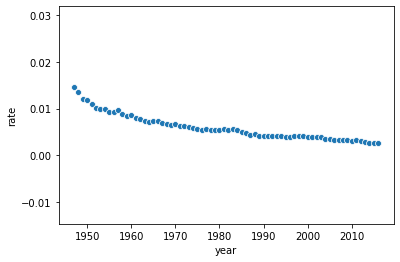

In [3]:
sns.scatterplot(df_50["year"],df_50["rate"])

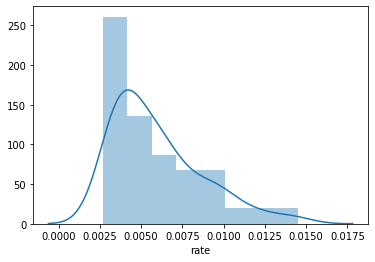

In [4]:
sns.distplot(df_50["rate"])

In [5]:
rate = df_50["rate"].to_numpy().reshape(-1,1)
year = df_50["year"].to_numpy().reshape(-1,1)

In [6]:
sa_1 = CWGP("box_cox",n=2)
sal_1 = CWGP("sal",n=2)

[  0.97038313 265.29236436]


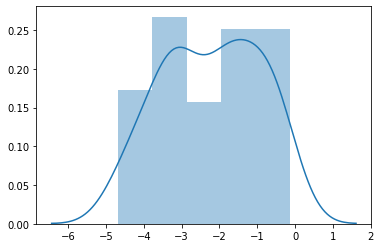

In [8]:
p_1 = sa_1.fit(rate).x
print(p_1)
x_1, d = sa_1.phi.comp_phi(p_1,rate)
sns.distplot(x_1)

 /home/chen/work/venv/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:35: RuntimeWarning:overflow encountered in multiply
 /home/chen/work/venv/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning:overflow encountered in multiply
 /home/chen/work/venv/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:88: RuntimeWarning:overflow encountered in multiply
 /home/chen/work/venv/lib/python3.6/site-packages/cwgp/transformations.py:5: RuntimeWarning:overflow encountered in multiply


[-2.51000755e+02  9.86644816e+02  1.11087624e+00  2.27477909e+00
 -8.84005227e-01  7.37307664e-02  5.77643104e-01 -3.53293297e-01]


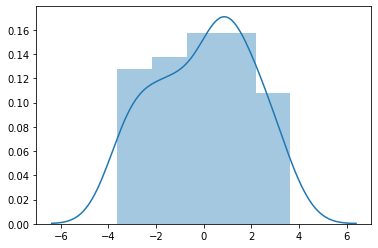

In [10]:
p_2 = sal_1.fit(x_1).x
print(p_2)
x_2, d = sal_1.phi.comp_phi(p_2,x_1)
sns.distplot(x_2)


Name : GP regression
Objective : -413.77431779027387
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |  priors
  Mat52.variance           |  0.00015401908015031475  |      +ve      |        
  Mat52.lengthscale        |       27.47422553536069  |      +ve      |        
  Gaussian_noise.variance  |   2.283962832493943e-08  |      +ve      |        


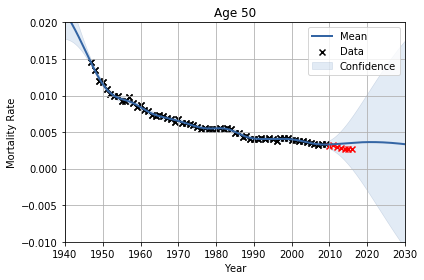

In [18]:
kernel = GPy.kern.Matern52(1)

ratio = 0.9
length = len(df_50)
train = int(ratio*length)
train_up, train_low = train, train-train


model_cwgp = GPy.models.GPRegression(df_50.year[:, None][train_low:train_up], df_50.rate[:, None][train_low:train_up], kernel=kernel)
model_cwgp.optimize()
print(model_cwgp)
model_cwgp.plot(plot_limits=[1940,2030])
plt.scatter(year[train_low:train_up], rate[train_low:train_up], marker="x", color='black')
plt.scatter(year[train_up:], rate[train_up:], marker="x", color='red')
plt.scatter(year[:train_low], rate[:train_low], marker="x", color='red')

plt.title('Age ' + str(50))
plt.xlabel('Year')
plt.ylabel('Mortality Rate')
plt.ylim([-0.01,0.02])

plt.grid(True)
plt.show()


Name : GP regression
Objective : 17.10453836383568
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |  priors
  Mat52.variance           |   4.464282288324108  |      +ve      |        
  Mat52.lengthscale        |  15.224442722290677  |      +ve      |        
  Gaussian_noise.variance  |  0.0441477825300662  |      +ve      |        


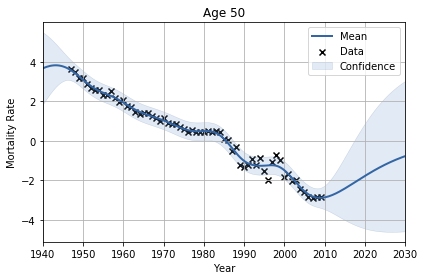

In [19]:
model_cwgp = GPy.models.GPRegression(df_50.year[:, None][train_low:train_up], x_2[train_low:train_up], kernel=kernel)
model_cwgp.optimize()
print(model_cwgp)
model_cwgp.plot(plot_limits=[1940,2030])

plt.title('Age ' + str(50))
plt.xlabel('Year')
plt.ylabel('Mortality Rate')

plt.grid(True)
plt.show()

In [20]:
data = []
for i in range(1940,2031):
    data.append(model_cwgp.predict(np.array(i).reshape(1,-1)))
tr_data = np.array(data).reshape(-1,1,2)


In [21]:
CI = 1.96
mean = tr_data[:,:,0]
var_upper = mean + CI*np.sqrt(tr_data[:,:,1])
var_lower = mean - CI*np.sqrt(tr_data[:,:,1])
predict_mean = sal_1.phi.inv_comp_phi(p_2,mean)
predict_mean = sa_1.phi.inv_comp_phi(p_1,predict_mean)
predict_var_upper = sal_1.phi.inv_comp_phi(p_2,var_upper)
predict_var_upper = sa_1.phi.inv_comp_phi(p_1,predict_var_upper)
predict_var_lower = sal_1.phi.inv_comp_phi(p_2,var_lower)
predict_var_lower = sa_1.phi.inv_comp_phi(p_1,predict_var_lower)

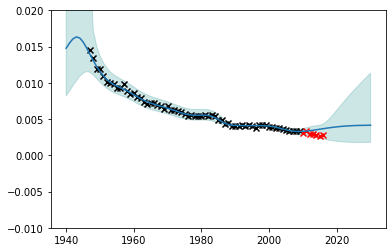

In [22]:
plt.fill_between(np.linspace(1940,2030,91),np.ravel(predict_var_upper),np.ravel(predict_var_lower),color=(0,0.5,0.5,0.2))
plt.scatter(year[train_low:train_up], rate[train_low:train_up], marker="x", color='black')
plt.scatter(year[train_up:], rate[train_up:], marker="x", color='red')
plt.scatter(year[:train_low], rate[:train_low], marker="x", color='red')
plt.ylim([-0.01,0.02])
plt.plot(np.linspace(1940,2030,91),predict_mean)
